# **BigMart Sales Prediction**

-----------------------------
## **Context**
-----------------------------

In today’s modern world, huge shopping centers such as big malls and marts are recording data related to sales of items or products as an important step to predict the sales and get an idea about future demands that can help with inventory management. Understanding what role certain properties of an item play and how they affect their sales is imperative to any retail business

The Data Scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. Using this data, **BigMart is trying to understand the properties of products and stores which play a key role in increasing sales**.

-----------------------------
## **Objective** 
-----------------------------

To build a predictive model that can find out the sales of each product at a particular store and then provide actionable recommendations to the BigMart sales team to understand the properties of products and stores which play a key role in increasing sales.

-----------------------------
## **Dataset** 
-----------------------------

- Item_Identifier : Unique product ID

- Item_Weight : Weight of the product

- Item_Fat_Content : Whether the product is low fat or not

- Item_Visibility : The % of the total display area of all products in a store allocated to the particular product

- Item_Type : The category to which the product belongs

- Item_MRP : Maximum Retail Price (list price) of the product

- Outlet_Identifier : Unique store ID

- Outlet_Establishment_Year : The year in which the store was established

- Outlet_Size : The size of the store in terms of ground area covered

- Outlet_Location_Type : The type of city in which the store is located

- Outlet_Type : Whether the outlet is just a grocery store or some sort of supermarket

- Item_Outlet_Sales : Sales of the product in the particular store. This is the outcome variable to be predicted.

We have two datasets - train (8523) and test (5681) data. The training dataset has both input and output variable(s). You will need to predict the sales for the test dataset.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

## **Importing the libraries and overview of the dataset**

In [1]:
# Importing libraries for data manipulation
import numpy as np

import pandas as pd

# Importing libraries for data visualization
import seaborn as sns

import matplotlib.pyplot as plt

# Importing libraries for building linear regression model
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### **Loading the datasets**

In [2]:
# Loading both train and test datasets

train_df = pd.read_csv('Train.csv')

test_df = pd.read_csv('Test.csv')

In [3]:
# Checking the first 5 rows of the dataset
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Observations:**

- As the variables **Item_Identifier** and **Outlet_Identifier** are only ID variables, we assume that they don't have any predictive power to predict the dependent variable - **Item_Outlet_Sales**.
- We will remove these two variables from both the datasets.

In [4]:
train_df = train_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis = 1)

test_df = test_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis = 1)

Now, let's find out some more information about the training dataset, i.e., the total number of observations in the dataset, columns and their data types, etc.

### **Checking the info of the training data**

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


**Observations:**

- The train dataset has **8523 observations and 10 columns**. 
- Two columns **Item_Weight** and **Outlet_Size** have missing values as the number of non-null values is less the total number of observations for these two variables.
- We observe that the columns **Item_Fat_Content**, **Item_Type**, **Outlet_Size**, **Outlet_Location_Type**, and **Outlet_Type** have data type **object**, which means they are strings or categorical variables.
- The remaining variables are all numerical in nature.

As we have already seen, two columns have missing values in the dataset. Let's check the **percentage of missing values** using the below code.

In [6]:
(train_df.isnull().sum() / train_df.shape[0])*100

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

The percentage of missing values for the columns **Item_Weight** and **Outlet_Size** is ~17% and ~28% respectively. Now, let's see next how to treat these missing values.

## **EDA and Data Preprocessing**

Now that we have an understanding of the business problem we want to solve, and we have loaded the datasets, the next step to follow is to have a better understanding of the dataset, i.e., what is the distribution of the variables, what are different relationships that exist between variables, etc. If there are any data anomalies like missing values or outliers, how do we treat them to prepare the dataset for building the predictive model?

### **Univariate Analysis**

Let us now start exploring the dataset, by performing univariate analysis of the dataset, i.e., analyzing/visualizing the dataset by taking one variable at a time. Data visualization is a very important skill to have and we need to decide what charts to plot to better understand the data. For example, what chart makes sense to analyze categorical variables or what charts are suited for numerical variables, and also it depends on what relationship between variables we want to show.

Let's start with analyzing the **categorical** variables present in the data. There are five categorical variables in this dataset and we will create univariate bar charts for each of them to check their distribution. 

Below we are creating 4 subplots to plot four out of the five categorical variables in a single frame.

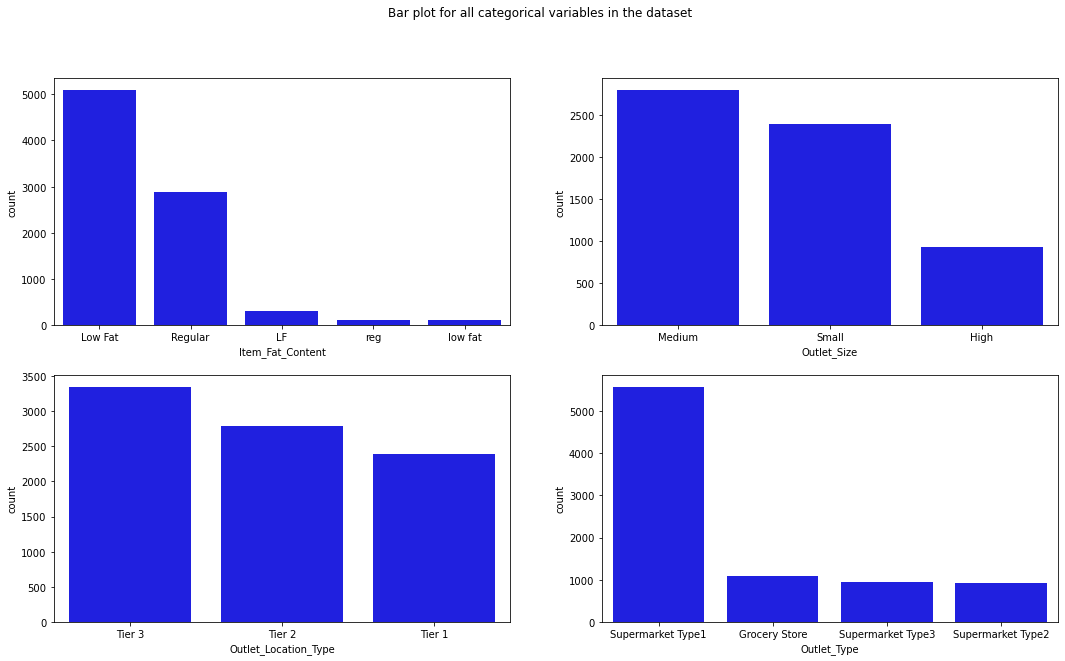

In [7]:
fig, axes = plt.subplots(2, 2, figsize = (18, 10))
  
fig.suptitle('Bar plot for all categorical variables in the dataset')

sns.countplot(ax = axes[0, 0], x = 'Item_Fat_Content', data = train_df, color = 'blue', 
              order = train_df['Item_Fat_Content'].value_counts().index);

sns.countplot(ax = axes[0, 1], x = 'Outlet_Size', data = train_df, color = 'blue', 
              order = train_df['Outlet_Size'].value_counts().index);

sns.countplot(ax = axes[1, 0], x = 'Outlet_Location_Type', data = train_df, color = 'blue', 
              order = train_df['Outlet_Location_Type'].value_counts().index);

sns.countplot(ax = axes[1, 1], x = 'Outlet_Type', data = train_df, color = 'blue', 
              order = train_df['Outlet_Type'].value_counts().index);

**Observations:**

- From the above univariate plot for the variable **Item_Fat_Content**, it seems like there are errors in the data. The category - **Low Fat** is also written as **low fat** and **LF**. Similarly, the category **Regular** is also written as **reg** sometimes. So, **we need to fix this issue in the data**.
- For the column **Outlet_Size**, we can see that the most common category is - **Medium** followed by Small and High.
- The most common category for the column **Outlet_Location_Type** is **Tier 3**, followed by Tier 2 and Tier 1. This makes sense now if we combine this information with the information on column **Outlet_Size**. We would expect High outlet size stores to be present in Tier 1 cities and the count of tier 1 cities is less so the count of high outlets size is also less. And we would expect more medium and small outlet sizes in the dataset because we have more number outlets present in tier 3 and tier 2 cities in the dataset.
- In the column **Outlet_Type**, the majority of the stores is of **Supermarket Type 1** and we have a less and almost equal number of representatives in the other categories - Supermarket Type 2, Supermarket Type 3, and Grocery Store.

Below we are analyzing the categorical variable **Item_Type**.

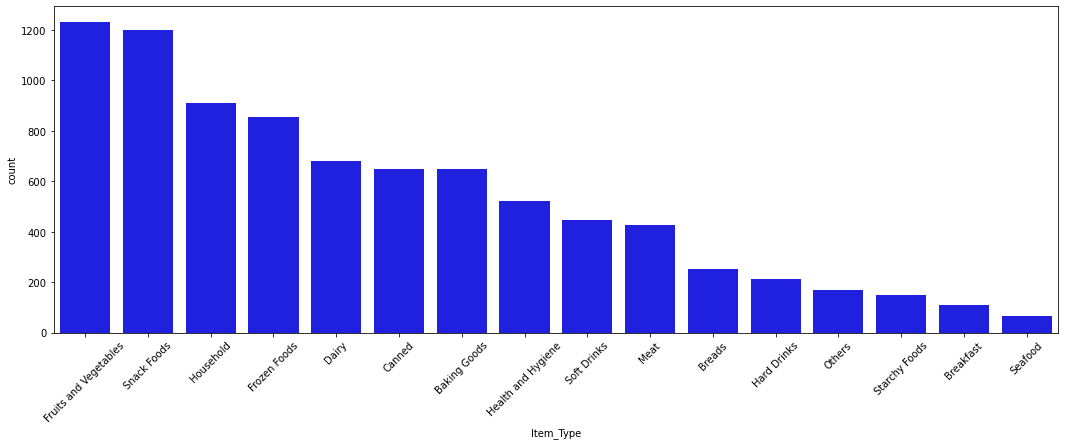

In [8]:
fig= plt.figure(figsize = (18, 6))

sns.countplot(x = 'Item_Type', data = train_df, color = 'blue', order = train_df['Item_Type'].value_counts().index);

plt.xticks(rotation = 45);

**Observation:**

- From the above plot, we observe that majority of the the items sold in these stores are **Fruits and Vegetables** , followed by **Snack Foods** and **Household items**.

Before we move ahead with the univariate analysis for the numerical variables, let's first fix the data issues that we have found for the column **Item_Fat_Content**.

In the below code, we are replacing the categories - **low fat** and **LF** by **Low Fat** using lambda function and also we are replacing the category **reg** by Regular.

In [9]:
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x == 'low fat' or x == 'LF' else x)

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Regular' if x == 'reg' else x)

The data preparation steps that we do on the training data, we need to perform the same steps on the test data as well. So, below we are performing the same transformations on the **test** dataset. 

In [10]:
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x == 'low fat' or x == 'LF' else x)

test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Regular' if x == 'reg' else x)

Below we are analyzing all the **numerical** variables present in the data. And since we want to visualize one numerical variable at a time, histogram is the best choice to visualize the data.

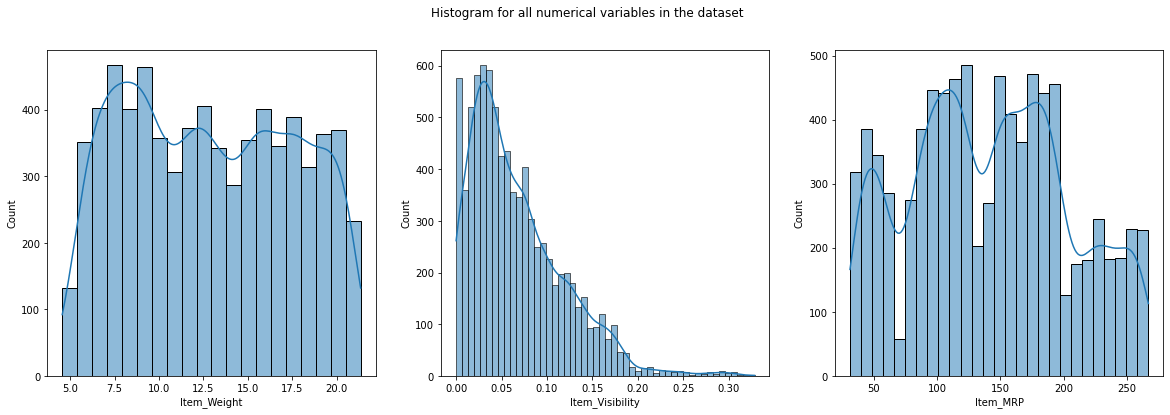

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))
  
fig.suptitle('Histogram for all numerical variables in the dataset')
  
sns.histplot(x = 'Item_Weight', data = train_df, kde = True, ax = axes[0]);

sns.histplot(x='Item_Visibility', data = train_df, kde = True, ax = axes[1]);

sns.histplot(x='Item_MRP', data = train_df, kde = True, ax = axes[2]);

#### **Observations:**

- The variable **Item_Weight** is approx uniformly distributed and when we will impute the missing values for this column, we will need to keep in mind that we don't end up changing the distribution significantly after imputing those missing values.
- The variable **Item_Visibility** is a right-skewed distribution which means that there are certain items whose percentage of the display area is much higher than the other items.
- The variable **Item_MRP** is following an approx multi-modal normal distribution.

### **Bivariate Analysis**

Now, let's move ahead with bivariate analysis to understand how variables are related to each other and if there is a strong relationship between dependent and independent variables present in the training dataset.

In the below plot, we are analyzing the variables **Outlet_Establishment_Year** and **Item_Outlet_Sales**. Here, since the variable **Outlet_Establishment_Year** is defining a time component, the best chart to analyze this relationship will be a line plot.

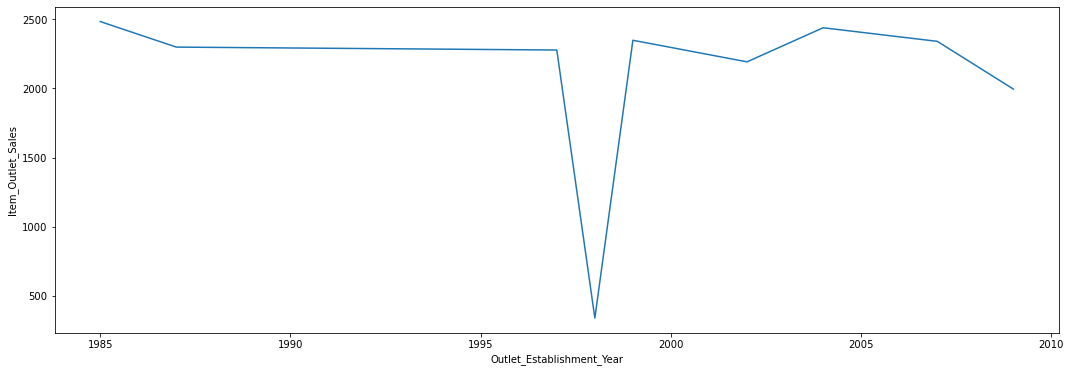

In [12]:
fig = plt.figure(figsize = (18, 6))

sns.lineplot(x = 'Outlet_Establishment_Year', y = 'Item_Outlet_Sales', data = train_df, ci = None, estimator = 'mean');

**Observations:**

- The average sales are almost constant every year, we don't see any increasing/decreasing trend in sales with time. So, the variable year might not be a good predictor to predict sales, which we can check later in the modeling phase.
- Also, in the year 1998, the average sales has plummeted. This might be due to some external factors which are not included in the data.

Next, we are trying to find out linear correlations between the variables. This will help us to know which numerical variables are correlated with the target variable. Also, we can find out **multi-collinearity**, i.e., which pair of independent variables are correlated with each other.

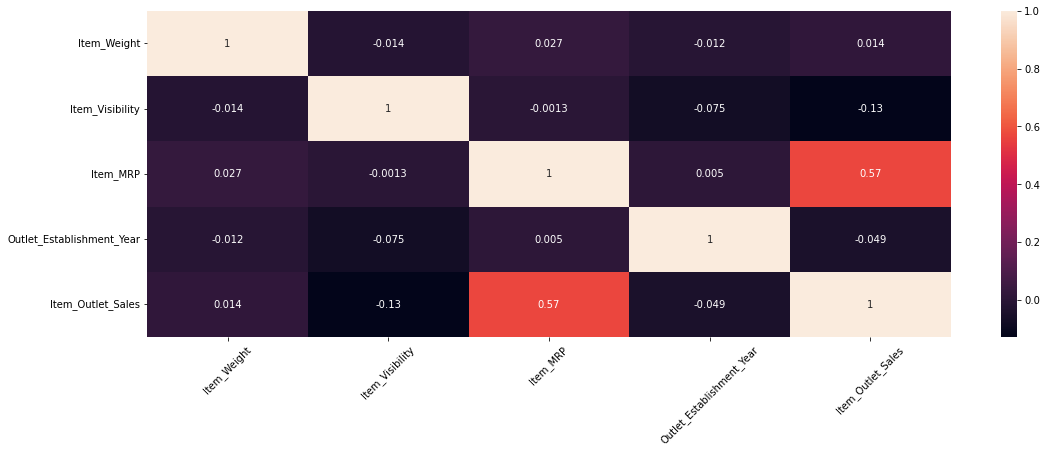

In [13]:
fig = plt.figure(figsize = (18, 6))

sns.heatmap(train_df.corr(), annot = True);

plt.xticks(rotation = 45);

**Observations:**

- From the above plot, it seems that only the independent variable **Item_MRP** has a moderate linear relationship with the dependent variable **Item_Outlet_Sales**.
- For the remaining, it does not seem like there is any strong positive/negative correlation between the variables.

Next, we are creating the bivariate scatter plots to check relationships between the pair of independent and dependent variables.

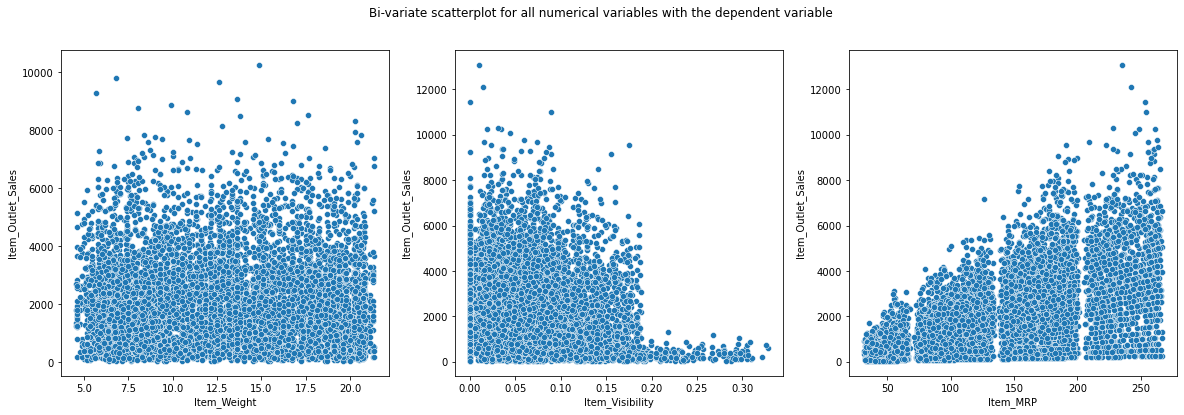

In [14]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))
  
fig.suptitle('Bi-variate scatterplot for all numerical variables with the dependent variable')
  
sns.scatterplot(x = 'Item_Weight', y = 'Item_Outlet_Sales', data = train_df, ax = axes[0]);

sns.scatterplot(x = 'Item_Visibility', y = 'Item_Outlet_Sales', data = train_df, ax = axes[1]);

sns.scatterplot(x = 'Item_MRP', y = 'Item_Outlet_Sales', data = train_df, ax = axes[2]);

**Observations:**

- The first scatter plot shows the data is completely random and there is no relationship between **Item_Weight** and **Item_outlet_Sales**. This is also evident from the correlation value which we got above, i.e., there is no strong correlation between these two variables.
- The second scatter plot between **Item_Visibility** and **Item_outlet_Sales** shows that there is no strong relationship between them. But we can see a pattern, as the **Item_Visibility** increases from **0.19**, the sales decrease. This might be due to the reason that the management has given more visibility to those items which are not generally sold often, thinking that better visibility would increase the sales. This information can also help us to engineer new features like - a categorical variable with categories - **high visibility** and **low visibility**. But we are not doing that here. This is an idea, we may want to pursue in the future.
- From the third scatter plot between the variables - **Item_MRP** and **Item_outlet_Sales**, it is clear that there is a positive correlation between them, and the variable **Item_MRP** would have a good predictive power to predict the sales.

### **Missing Value Treatment**

Here, we are imputing missing values for the variable **Item_Weight**. There are many ways to impute missing values, we can impute the missing values by its **mean**, **median**, and using advanced imputation algorithms like **knn**, etc. But, here we are trying to find out some relationship of the variable **Item_Weight** with other variables in the dataset to impute those missing values.

And also, after imputing the missing values for the variables, the overall distribution of the variable should not change significantly.

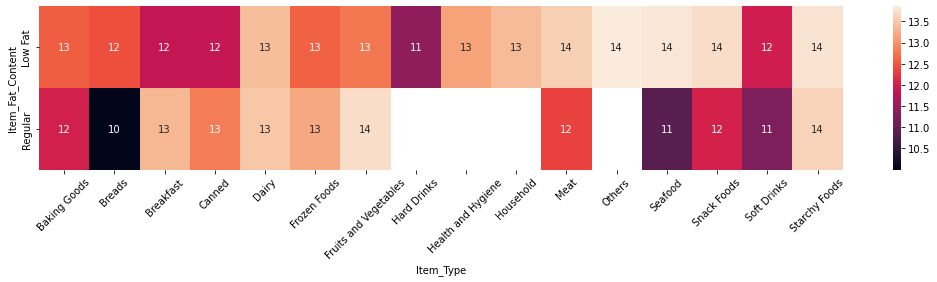

In [15]:
fig = plt.figure(figsize = (18, 3))

sns.heatmap(train_df.pivot_table(index = 'Item_Fat_Content', columns = 'Item_Type', values = 'Item_Weight'), annot = True);

plt.xticks(rotation = 45);

**Observation:**

- In the above heatmap, we can see that, based on different combinations of **Item_Types** and **Item_Fat_Content**, the average range of values for the column **Item_Weight** lies between the minimum value of 10 and the maximum value of 14.

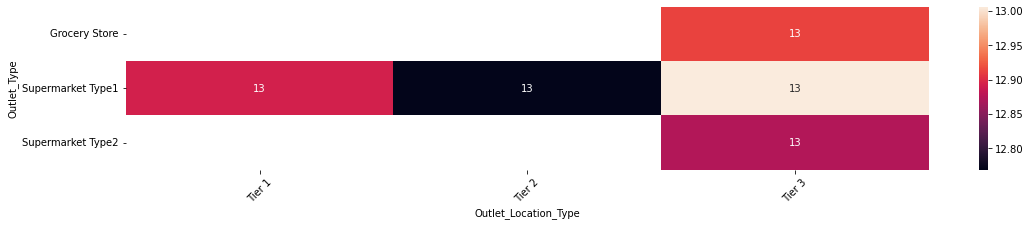

In [16]:
fig = plt.figure(figsize = (18, 3))

sns.heatmap(train_df.pivot_table(index = 'Outlet_Type', columns = 'Outlet_Location_Type', values = 'Item_Weight'), annot = True);

plt.xticks(rotation = 45);

**Observation:**

- In the above heatmap, we can see that, based on different combinations of **Outlet_Type** and **Outlet_Location_Type**, the average range of values for the column **Item_Weight** is constant at 13.

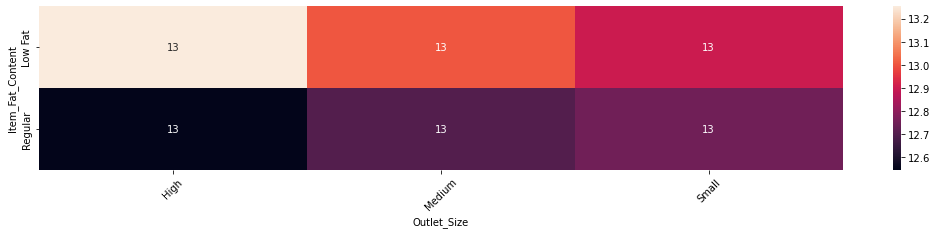

In [17]:
fig = plt.figure(figsize = (18, 3))

sns.heatmap(train_df.pivot_table(index = 'Item_Fat_Content', columns = 'Outlet_Size', values = 'Item_Weight'), annot = True);

plt.xticks(rotation = 45);

**Observation:**

- In the above heatmap, we can see that, based on different combinations of **Item_Fat_Content** and **Outlet_Size**, the average range of values for the column **Item_Weight** is also constant at 13.

We will impute the missing values using an uniform distribution with parameters a=10 and b=14, as shown below: 

In [18]:
item_weight_indices_to_be_updated = train_df[train_df['Item_Weight'].isnull()].index

train_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(10, 14, 
                                                                                   len(item_weight_indices_to_be_updated))

Performing the same transformation on the **test** dataset.

In [19]:
item_weight_indices_to_be_updated = test_df[test_df['Item_Weight'].isnull()].index

test_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(10, 14, 
                                                                                   len(item_weight_indices_to_be_updated))

Next, we will be imputing missing values for the column **Outlet_Size**. Below, we are creating two different datasets - one where we have non-null values for the column **Outlet_Size** and in the other dataset, all the values of the column **Outlet_Size** are missing. We then check the distribution of the other variables in the dataset where **Outlet_Size** is missing to identify if there is any pattern present or not.

In [20]:
outlet_size_data = train_df[train_df['Outlet_Size'].notnull()]

outlet_size_missing_data = train_df[train_df['Outlet_Size'].isnull()]

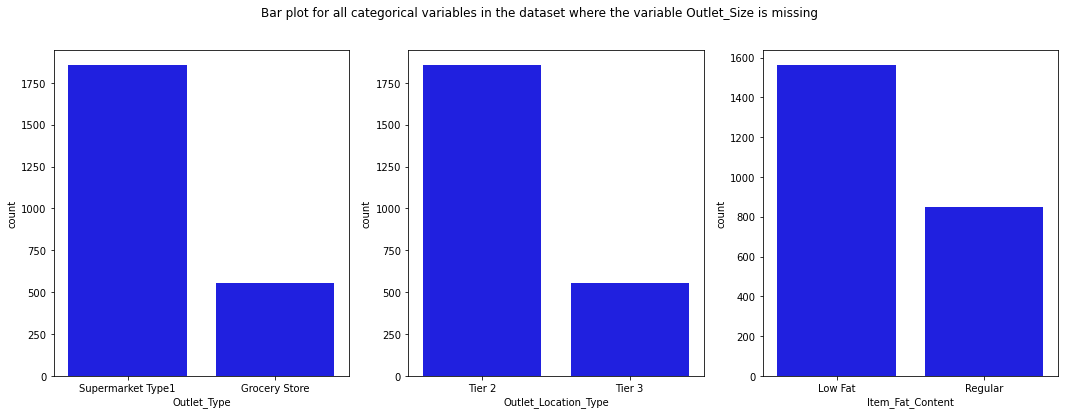

In [21]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))
  
fig.suptitle('Bar plot for all categorical variables in the dataset where the variable Outlet_Size is missing')
  
sns.countplot(ax = axes[0], x = 'Outlet_Type', data = outlet_size_missing_data, color = 'blue', 
              order = outlet_size_missing_data['Outlet_Type'].value_counts().index);

sns.countplot(ax = axes[1], x = 'Outlet_Location_Type', data = outlet_size_missing_data, color = 'blue', 
              order = outlet_size_missing_data['Outlet_Location_Type'].value_counts().index);

sns.countplot(ax = axes[2], x = 'Item_Fat_Content', data = outlet_size_missing_data, color = 'blue', 
              order = outlet_size_missing_data['Item_Fat_Content'].value_counts().index);

**Observation:**

- We can see that, wherever **Outlet_Size** is missing in the dataset, the majority of them have **Outlet_Type** as Supermarket Type 1, **Outlet_Location_Type** as Tier 2, and **Item_Fat_Content** as **Low Fat**.

Now, we are creating a cross-tab of all the above categorical variables against the column **Outlet_Size**, where we want to impute the missing values.

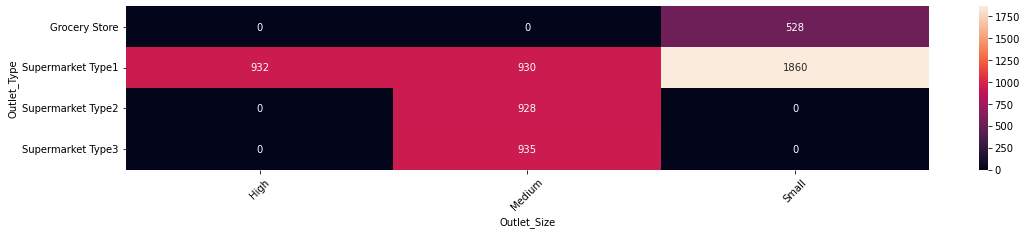

In [22]:
fig= plt.figure(figsize=(18, 3))

sns.heatmap(pd.crosstab(index = outlet_size_data['Outlet_Type'], columns = outlet_size_data['Outlet_Size']), annot = True, fmt = 'g')

plt.xticks(rotation=45);

**Observations:** 

- We observe from the above heatmap that all the grocery stores have **Outlet_Size** as small.
- All the Supermarket Type 2 and Supermarket Type 3 have **Outlet_Size** as Medium.

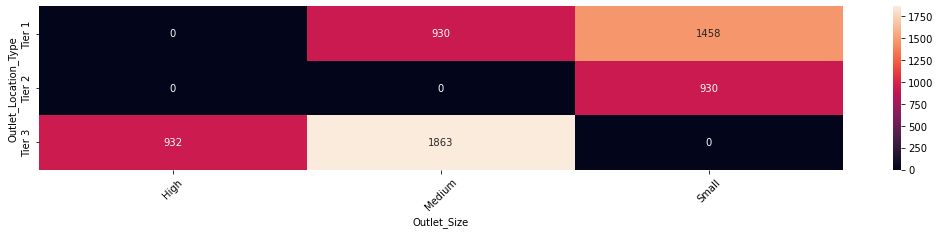

In [23]:
fig = plt.figure(figsize = (18, 3))

sns.heatmap(pd.crosstab(index = outlet_size_data['Outlet_Location_Type'], columns = outlet_size_data['Outlet_Size']), annot = True, fmt = 'g')

plt.xticks(rotation = 45);

**Observation:**

- We observe from the above heatmap that all the Tier 2 stores have **Outlet_Size** as Small.

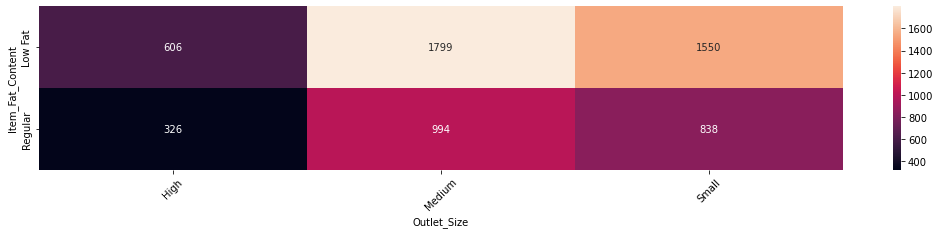

In [24]:
fig = plt.figure(figsize = (18, 3))

sns.heatmap(pd.crosstab(index = outlet_size_data['Item_Fat_Content'], columns = outlet_size_data['Outlet_Size']), annot = True, fmt = 'g')

plt.xticks(rotation = 45);

**Observation:**

- There does not seem to be any clear pattern between the variables **Item_Fat_Content** and **Outlet_Size**.

Now, we will use the patterns we have from the variables **Outlet_Type** and **Outlet_Location_Type** to impute the missing values for the column **Outlet_Size**.

Below, we are identifying the indices in the DataFrame where **Outlet_Size** is null/missing and **Outlet_Type** is Grocery Store, so that we can replace those missing values with the value Small based on the pattern we have identified in above visualizations. Similarly, we are also identifying the indices in the DataFrame where **Outlet_Size** is null/missing and **Outlet_Location_Type** is Tier 2, to impute those missing values.

In [25]:
grocery_store_indices = train_df[train_df['Outlet_Size'].isnull()].query(" Outlet_Type == 'Grocery Store' ").index

tier_2_indices = train_df[train_df['Outlet_Size'].isnull()].query(" Outlet_Location_Type == 'Tier 2' ").index

Now, we are updating those indices for the column **Outlet_Size** with the value Small.

In [26]:
train_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'

train_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

Performing the same transformations on the **test** dataset.

In [27]:
grocery_store_indices = test_df[test_df['Outlet_Size'].isnull()].query(" Outlet_Type == 'Grocery Store' ").index

tier_2_indices = test_df[test_df['Outlet_Size'].isnull()].query(" Outlet_Location_Type == 'Tier 2' ").index

In [28]:
test_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'

test_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

After we have imputed the missing values, let's check again if we still have missing values in both train and test datasets. 

In [29]:
train_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [30]:
test_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

There are **no missing values** in the datasets.

### **Feature Engineering**

Now that we have completed the data understanding and data preparation step, before starting with the modeling task, we think that certain features are not present in the dataset, but we can create them using the existing columns, which can have the predictive power to predict the sales. This step of creating a new feature from the existing features in the dataset is known as **Feature Engineering**. So, we will start with a hypothesis - As the store gets older, the sales increase. Now, how do we define old? We know the establishment year and this data is collected in 2013, so the age can be found by subtracting the establishment year from 2013. This is what we are doing in the below code.

We are creating a new feature **Outlet_Age** which indicates how old the outlet is.

In [31]:
train_df['Outlet_Age'] = 2013 - train_df['Outlet_Establishment_Year']

test_df['Outlet_Age'] = 2013 - test_df['Outlet_Establishment_Year']

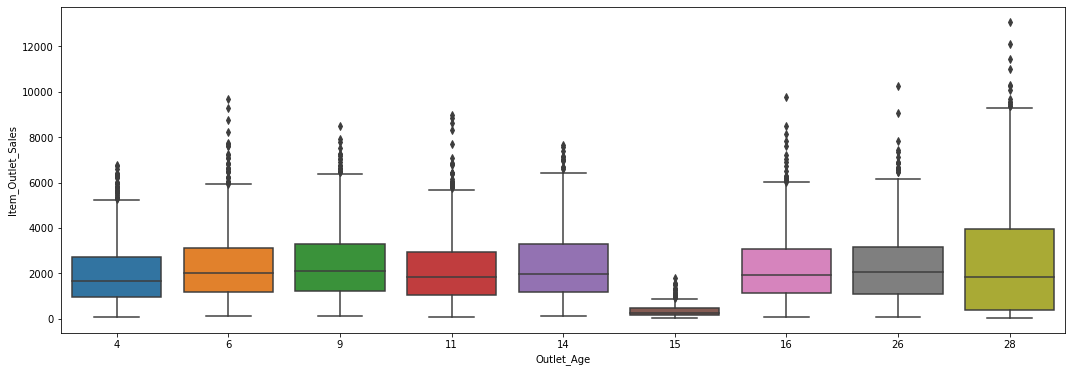

In [32]:
fig = plt.figure(figsize = (18, 6))

sns.boxplot(x = 'Outlet_Age', y = 'Item_Outlet_Sales', data = train_df);

**Observations:**
* The hypothesis that we had - **As the store gets older, the sales increase** does not seem to hold based on the above plot. Because of the different ages of stores, the sales have similar distribution approximately. But let's keep this variable as of now, and we will revisit this variable at the time of model building and we can remove this variable by observing its significance later on.

## **Modeling**

Now, that we have analyzed all the variables in the dataset, we are ready to start building the model. We have observed that not all the independent variables are important to predict the outcome variable. But at the beginning, we will use all the variables, and then from the model summary, we will decide on which variable to remove from the model. Model building is an iterative task.

In [33]:
# We are removing the outcome variable from the feature set
# Also removing the variable Outlet_Establishment_Year, as we have created a new variable Outlet_Age
train_features = train_df.drop(['Item_Outlet_Sales', 'Outlet_Establishment_Year'], axis = 1)

# And then we are extracting the outcome variable separately
train_target = train_df['Item_Outlet_Sales']

Whenever we have categorical variables as independent variables, we need to create **one hot encoded** representation (which is also known as dummy variables) of those categorical variables. The below code is creating dummy variables and we are removing the first category in those variables, known as **reference variable**. The reference variable helps to interpret the linear regression which we will see later.

In [34]:
# Creating dummy variables for the categorical variables
train_features = pd.get_dummies(train_features, drop_first = True)

train_features.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,14,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,4,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,17.50,0.016760,141.6180,14,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,15,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,8.93,0.000000,53.8614,26,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


**Observations:**

- Notice that the column names of all the categorical variables, and also the overall number of columns has increased after we created the dummy variables.
- For each of those categorical variables, the first category has been removed, e.g., the category **Low Fat** of the categorical variable **Item_Fat_Content** has been removed and became the **reference variable**, and we only have the category **Regular** as a new column **Item_Fat_Content_Regular**.

Below, we are scaling the numerical variables in the dataset to have the same range. If we don't do this, then the model will be biased towards a variable where we have a higher range and the model will not learn from the variables with a lower range. There are many ways to do scaling. Here, we are using **MinMaxScaler** as we have both categorical and numerical variables in the dataset and don't want to change the dummy encodings of the categorical variables that we have already created. For more information on different ways of doing scaling, refer to the **section 6.3.1** of this page [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)

In [35]:
# Creating an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Applying fit_transform on the training features data
train_features_scaled = scaler.fit_transform(train_features)

# The above scaler returns the data in array format, below we are converting it back to pandas DataFrame
train_features_scaled = pd.DataFrame(train_features_scaled, index = train_features.index, columns = train_features.columns)

train_features_scaled.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.282525,0.048866,0.927507,0.416667,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.081274,0.058705,0.072068,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.770765,0.051037,0.468288,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.871986,0.000000,0.640093,0.458333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.260494,0.000000,0.095805,0.916667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Now, as the dataset is ready, we are set to build the model using the **statsmodels** package.

In [36]:
# Adding the intercept term
train_features_scaled = sm.add_constant(train_features_scaled)

# Calling the OLS algorithm on the train features and the target variable
ols_model_0 = sm.OLS(train_target, train_features_scaled)

# Fitting the Model
ols_res_0 = ols_model_0.fit()

print(ols_res_0.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     405.8
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:10:59   Log-Likelihood:                -71993.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8495   BIC:                         1.442e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

**Observations:**

- We can see that the **R-squared** for the model is **0.563**. 
- Not all the variables are statistically significant to predict the outcome variable. To check which variables are statistically significant or have predictive power to predict the target variable, we need to check the **p-value** against all the independent variables.

**Interpreting the Regression Results:**

1. **Adj. R-squared**: It reflects the fit of the model.
    - Adjusted R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for Adjusted R-squared is **0.562**.

2. **coeff**: It represents the change in the output Y due to a change of one unit in the independent variable (everything else held constant).
3. **std err**: It reflects the level of accuracy of the coefficients.
    - The lower it is, the more accurate the coefficients are.
4. **P >|t|**: It is the p-value.
   
   * Pr(>|t|) : For each independent feature, there is a null hypothesis and alternate hypothesis.

    Ho : Independent feature is not significant. 
   
    Ha : Independent feature is significant. 
    
   * The p-value of less than 0.05 is considered to be statistically significant with a confidence level of 95%. 

   
5. **Confidence Interval**: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).

To understand in detail how p-values can help to identify statistically significant variables to predict the sales, we need to understand the hypothesis testing framework.

In the following example, we are showing the null hypothesis between the independent variable **Outlet_Size** and the dependent variable **Item_Outlet_Sales** to identify if there is any relationship between them or not.

- **Null hypothesis:** There is nothing going on or there is no relationship between variables **Outlet_Size** and **Item_Outlet_Sales**, i.e.

<center>$\mu_{\text {outlet size }=\text { High }}=\mu_{\text {outlet size }=\text { Medium }}=\mu_{\text {outlet size }=\text { Small }}$</center> where, $\mu$ represents mean sales.

- **Alternate hypothesis:** There is something going on, because of which, there is a relationship between variables **Outlet_Size** and **Item_Outlet_Sales**, i.e. 

<center>$\mu_{\text {outlet size = High }} \neq \mu_{\text {outlet size = Medium }} \neq \mu_{\text {outlet size }=\text { small }}$</center> where, $\mu$ represents mean sales.

From the above model summary, if the p-value is less than the significance level of 0.05, then we will reject the null hypothesis in favor of the alternate hypothesis. In other words, we have enough statistical evidence that there is some relationship between the variables **Outlet_Size** and **Item_Outlet_Sales**.

Based on the above analysis, if we observe the above model summary, we can see only some of the variables or some of the categories of a categorical variables have a p-value lower than 0.05.

## **Feature Selection**

### **Removing Multicollinearity**


* Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent. If the correlation between independent variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.

* There are different ways of detecting (or testing) multicollinearity. One such way is the Variation Inflation Factor.

* **Variance Inflation factor**:  Variance inflation factor measures the inflation in the variances of the regression parameter estimates due to collinearities that exist among the predictors.  It is a measure of how much the variance of the estimated regression coefficient βk is “inflated” by the existence of correlation among the predictor variables in the model. 

* General Rule of thumb: If VIF is 1, then there is no correlation between the kth predictor and the remaining predictor variables, and hence the variance of β̂k is not inflated at all. Whereas, if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeds 10, it shows signs of high multicollinearity.

In [37]:
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled.values, i) for i in range(train_features_scaled.shape[1])],
    index = train_features_scaled.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                              1726.732539
Item_Weight                           1.020069
Item_Visibility                       1.101104
Item_MRP                              1.013097
Outlet_Age                           50.920770
Item_Fat_Content_Regular              1.216554
Item_Type_Breads                      1.349903
Item_Type_Breakfast                   1.158313
Item_Type_Canned                      1.853160
Item_Type_Dairy                       1.906299
Item_Type_Frozen Foods                2.093663
Item_Type_Fruits and Vegetables       2.497446
Item_Type_Hard Drinks                 1.331158
Item_Type_Health and Hygiene          1.772040
Item_Type_Household                   2.289738
Item_Type_Meat                        1.581380
Item_Type_Others                      1.264019
Item_Type_Seafood                     1.091672
Item_Type_Snack Foods                 2.469391
Item_Type_Soft Drinks                 1.629102
Item_Type_Starchy Foods               1.211472

Outlet_Age has a high VIF score. Hence, we are dropping Outlet_Age and building the model.

In [38]:
train_features_scaled_new = train_features_scaled.drop("Outlet_Age", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new.values, i) for i in range(train_features_scaled_new.shape[1])],
    index = train_features_scaled_new.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                              121.234210
Item_Weight                          1.019998
Item_Visibility                      1.101084
Item_MRP                             1.013056
Item_Fat_Content_Regular             1.216511
Item_Type_Breads                     1.349602
Item_Type_Breakfast                  1.158304
Item_Type_Canned                     1.853098
Item_Type_Dairy                      1.906296
Item_Type_Frozen Foods               2.093418
Item_Type_Fruits and Vegetables      2.497273
Item_Type_Hard Drinks                1.331077
Item_Type_Health and Hygiene         1.772005
Item_Type_Household                  2.289719
Item_Type_Meat                       1.581366
Item_Type_Others                     1.263965
Item_Type_Seafood                    1.091509
Item_Type_Snack Foods                2.469340
Item_Type_Soft Drinks                1.629097
Item_Type_Starchy Foods              1.211469
Outlet_Size_Medium                  10.996151
Outlet_Size_Small   

Now, let's build the model and observe the p-values.

In [39]:
ols_model_2 = sm.OLS(train_target, train_features_scaled_new)

ols_res_2 = ols_model_2.fit()

In [40]:
print(ols_res_2.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     420.6
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:00   Log-Likelihood:                -71997.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8496   BIC:                         1.442e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

It is not a good practice to consider VIF values for dummy variables as they are correlated to other categories and hence have a high VIF usually. So, we built the model and calculated the p-values. We can see that all the categories in the Item_Type column show a p-value higher than 0.05. So, we can drop the Item_Type column.

In [41]:
train_features_scaled_new2 = train_features_scaled_new.drop(['Item_Type_Breads',
'Item_Type_Breakfast',
'Item_Type_Canned',
'Item_Type_Dairy',
'Item_Type_Frozen Foods',
'Item_Type_Fruits and Vegetables',
'Item_Type_Hard Drinks',
'Item_Type_Health and Hygiene',
'Item_Type_Household',
'Item_Type_Meat',
'Item_Type_Others',
'Item_Type_Seafood',
'Item_Type_Snack Foods',
'Item_Type_Soft Drinks',
'Item_Type_Starchy Foods'], axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new2.values, i) for i in range(train_features_scaled_new2.shape[1])],
    index = train_features_scaled_new2.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                            109.302904
Item_Weight                        1.007465
Item_Visibility                    1.093183
Item_MRP                           1.000658
Item_Fat_Content_Regular           1.003054
Outlet_Size_Medium                10.986397
Outlet_Size_Small                 12.268475
Outlet_Location_Type_Tier 2        2.689564
Outlet_Location_Type_Tier 3        7.531382
Outlet_Type_Supermarket Type1      5.947977
Outlet_Type_Supermarket Type2      4.226075
Outlet_Type_Supermarket Type3      4.260682
dtype: float64



In [42]:
ols_model_3 = sm.OLS(train_target, train_features_scaled_new2)

ols_res_3 = ols_model_3.fit()

print(ols_res_3.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     994.9
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:00   Log-Likelihood:                -72000.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8511   BIC:                         1.441e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Now, from the p-values, we can see that we can remove the Item_Weight column as it has the highest p-value, i.e., it is the most insignificant variable.

In [43]:
train_features_scaled_new3 = train_features_scaled_new2.drop("Item_Weight", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new3.values, i) for i in range(train_features_scaled_new3.shape[1])],
    index = train_features_scaled_new3.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                            106.905754
Item_Visibility                    1.093065
Item_MRP                           1.000167
Item_Fat_Content_Regular           1.002641
Outlet_Size_Medium                10.977215
Outlet_Size_Small                 12.259457
Outlet_Location_Type_Tier 2        2.689448
Outlet_Location_Type_Tier 3        7.519408
Outlet_Type_Supermarket Type1      5.938545
Outlet_Type_Supermarket Type2      4.225983
Outlet_Type_Supermarket Type3      4.255095
dtype: float64



Let's build the model again.

In [44]:
ols_model_4 = sm.OLS(train_target, train_features_scaled_new3)

ols_res_4 = ols_model_4.fit()

print(ols_res_4.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1095.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:01   Log-Likelihood:                -72000.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8512   BIC:                         1.441e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

From the above p-values, both the categories of the column Outlet_Location_Type have a p-value lower than 0.05. So, we can remove the categories of Outlet_Location_Type.

In [45]:
train_features_scaled_new4 = train_features_scaled_new3.drop(["Outlet_Location_Type_Tier 2", "Outlet_Location_Type_Tier 3"], axis=1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new4.values, i) for i in range(train_features_scaled_new4.shape[1])],
    index = train_features_scaled_new4.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                            27.169808
Item_Visibility                   1.092348
Item_MRP                          1.000143
Item_Fat_Content_Regular          1.002605
Outlet_Size_Medium                4.034011
Outlet_Size_Small                 2.814532
Outlet_Type_Supermarket Type1     2.478493
Outlet_Type_Supermarket Type2     2.842880
Outlet_Type_Supermarket Type3     2.863427
dtype: float64



In [46]:
ols_model_5 = sm.OLS(train_target, train_features_scaled_new4)

ols_res_5 = ols_model_5.fit()

print(ols_res_5.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1368.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:01   Log-Likelihood:                -72001.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8514   BIC:                         1.441e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

From the above p-values, both the categories of the column Outlet_Size have a p-value lower than 0.05. So, we can remove the categories of Outlet_Size.

In [47]:
train_features_scaled_new5 = train_features_scaled_new4.drop(["Outlet_Size_Small", "Outlet_Size_Medium"], axis=1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new5.values, i) for i in range(train_features_scaled_new5.shape[1])],
    index=train_features_scaled_new5.columns,
    dtype=float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                            15.813401
Item_Visibility                   1.092314
Item_MRP                          1.000114
Item_Fat_Content_Regular          1.002581
Outlet_Type_Supermarket Type1     2.306663
Outlet_Type_Supermarket Type2     1.731428
Outlet_Type_Supermarket Type3     1.744734
dtype: float64



In [48]:
ols_model_6 = sm.OLS(train_target, train_features_scaled_new5)
ols_res_6 = ols_model_6.fit()
print(ols_res_6.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1824.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:01   Log-Likelihood:                -72002.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8516   BIC:                         1.441e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Finally, let's drop the Item_Visibility.

In [49]:
train_features_scaled_new6 = train_features_scaled_new5.drop("Item_Visibility", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new6.values, i) for i in range(train_features_scaled_new6.shape[1])],
    index = train_features_scaled_new6.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                            11.452496
Item_MRP                          1.000114
Item_Fat_Content_Regular          1.000048
Outlet_Type_Supermarket Type1     2.125686
Outlet_Type_Supermarket Type2     1.654765
Outlet_Type_Supermarket Type3     1.658941
dtype: float64



In [50]:
ols_model_7 = sm.OLS(train_target, train_features_scaled_new6)
ols_res_7 = ols_model_7.fit()
print(ols_res_7.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     2188.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:01   Log-Likelihood:                -72003.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8517   BIC:                         1.441e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

**Observations:**

- All the VIF Scores are now less than 5 indicating no multicollinearity.
- Now, all the p values are lesser than 0.05 implying all the current variables are significant for the model.
- The R-Squared value did not change by much. It is still coming out to be ~0.56 which implies that all other variables were not adding any value to the model.

Lets' check the assumptions of the linear regression model.

## **Checking for the assumptions and rebuilding the model**

In this step, we will check whether the below assumptions hold true or not for the model. In case there is an issue, we will rebuild the model after fixing those issues.

1. Mean of residuals should be 0
2. Normality of error terms
3. Linearity of variables
4. No heteroscedasticity

### **Mean of residuals should be 0 and normality of error terms**

In [51]:
# Residuals
residual = ols_res_7.resid 

In [52]:
residual.mean()

2.3302933884742838e-14

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

### **Tests for Normality**

**What is the test?**

* Error terms/Residuals should be normally distributed.

* If the error terms are non-normally distributed, confidence intervals may become too wide or narrow. Once the confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on the minimization of least squares.

**What does non-normality indicate?**

* It suggests that there are a few unusual data points that must be studied closely to make a better model.

**How to check the normality?**

* We can plot the histogram of residuals and check the distribution visually.

* It can be checked via QQ Plot. Residuals following normal distribution will make a straight line plot otherwise not.

* Another test to check for normality: The Shapiro-Wilk test.

**What if the residuals are not-normal?**

* We can apply transformations like log, exponential, arcsinh, etc. as per our data.

<AxesSubplot:ylabel='Count'>

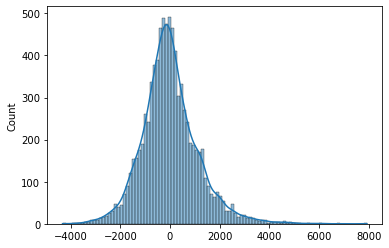

In [53]:
# Plot histogram of residuals
sns.histplot(residual, kde = True)

We can see that the error terms are normally distributed. The assumption of normality is satisfied.

### **Linearity of Variables**

It states that the predictor variables must have a linear relation with the dependent variable.

To test this assumption, we'll plot the residuals and the fitted values and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

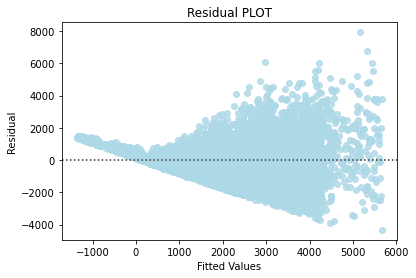

In [54]:
# Predicted values
fitted = ols_res_7.fittedvalues

sns.residplot(x = fitted, y = residual, color = "lightblue")

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

**Observations:**

- We can see that there is some pattern in fitted values and residuals, i.e., the residuals are not randomly distributed.
- Let's try to fix this. We can apply the log transformation on the target variable and try to build a new model.

In [55]:
# Log transformation on the target variable
train_target_log = np.log(train_target)

In [56]:
# Fitting new model with the transformed target variable
ols_model_7 = sm.OLS(train_target_log, train_features_scaled_new6)

ols_res_7 = ols_model_7.fit()

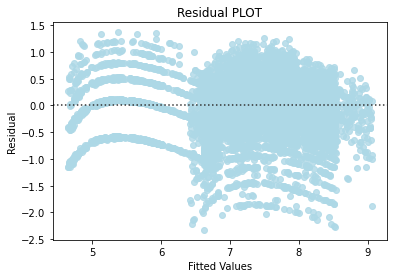

In [57]:
# Predicted values
fitted = ols_res_7.fittedvalues

residual1 = ols_res_7.resid

sns.residplot(x = fitted, y = residual1, color = "lightblue")

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

**Observations:**

- We can see that there is no pattern in the residuals vs fitted values scatter plot now, i.e., the linearity assumption is satisfied.
- Let's check the model summary of the latest model we have fit. 

In [58]:
print(ols_res_7.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     4375.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:11:02   Log-Likelihood:                -6816.7
No. Observations:                8523   AIC:                         1.365e+04
Df Residuals:                    8517   BIC:                         1.369e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

- The model performance has improved significantly. The R-Squared has increased from 0.56 to 0.720.

Let's check the final assumption of homoscedasticity.

### **No Heteroscedasticity**

#### **Test for Homoscedasticity**

* **Homoscedasticity -** If the variance of the residuals are symmetrically distributed across the regression line, then the data is said to homoscedastic.

* **Heteroscedasticity -** If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case, the residuals can form an arrow shape or any other non symmetrical shape.

- We will use Goldfeld–Quandt test to check homoscedasticity.

    - Null hypothesis : Residuals are homoscedastic

    - Alternate hypothesis : Residuals are hetroscedastic

In [59]:
from statsmodels.stats.diagnostic import het_white

from statsmodels.compat import lzip

import statsmodels.stats.api as sms

In [60]:
import statsmodels.stats.api as sms

from statsmodels.compat import lzip

name = ["F statistic", "p-value"]

test = sms.het_goldfeldquandt(train_target_log, train_features_scaled_new6)

lzip(name, test)

[('F statistic', 0.9395156175145155), ('p-value', 0.9790604597916552)]

- As we observe from the above test, the p-value is greater than 0.05, so we fail to reject the null-hypothesis. That means the residuals are homoscedastic.

We have verified all the assumptions of the linear regression model. The final equation of the model is as follows:

**$\log ($ Item_Outlet_Sales $)$ $= 4.6356 + 1.9555 *$ Item_MRP$ + 0.0158 *$ Item_Fat_Content_Regular $ + 1.9550 *$ Outlet_Type_Supermarket Type1 $ + 1.7737 *$ Outlet_Type_Supermarket Type2$ + 2.4837*$ Outlet_Type_Supermarket Type3**

Now, let's make the final test predictions.

In [61]:
without_const = train_features_scaled.iloc[:,1:]

test_features = pd.get_dummies(test_df, drop_first = True)

test_features = test_features[list(without_const)]

# Applying transform on the test data
test_features_scaled = scaler.transform(test_features)

test_features_scaled = pd.DataFrame(test_features_scaled, columns = without_const.columns)

test_features_scaled = sm.add_constant(test_features_scaled)

test_features_scaled = test_features_scaled.drop(["Item_Weight", "Item_Visibility", "Item_Type_Breads", "Item_Type_Breakfast", "Item_Type_Canned", "Item_Type_Dairy","Item_Type_Frozen Foods","Item_Type_Fruits and Vegetables", "Item_Type_Hard Drinks", "Item_Type_Health and Hygiene", "Item_Type_Household", "Item_Type_Meat", "Item_Type_Others", "Item_Type_Seafood", "Item_Type_Snack Foods", "Item_Type_Soft Drinks", "Item_Type_Starchy Foods", "Outlet_Size_Medium", "Outlet_Size_Small", "Outlet_Location_Type_Tier 2", "Outlet_Location_Type_Tier 3", 'Outlet_Age'], axis = 1)

test_features_scaled.head()

,const,Item_MRP,Item_Fat_Content_Regular,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,1.0,0.325012,0.0,1.0,0.0,0.0
1,1.0,0.237819,1.0,1.0,0.0,0.0
2,1.0,0.893316,0.0,0.0,0.0,0.0
3,1.0,0.525233,0.0,1.0,0.0,0.0
4,1.0,0.861381,1.0,0.0,0.0,1.0


## **Evaluation Metrics**

### **R-Squared**

The R-squared metric gives us an indication that how good/bad our model is from a baseline model. Here, we have explained ~98% variance in the data as compared to the baseline model when there is no independent variable.

In [62]:
print(ols_res_7.rsquared)

0.71975057509795


### **Mean Squared Error**

This metric measures the average of the squares of the errors, i.e., the average squared difference between the estimated values and the actual value.

In [63]:
print(ols_res_7.mse_resid)

0.29009080646817975


### **Root Mean Squared Error**

This metric is the same as the above but, instead of simply taking the average, we also take the square root of MSE to get RMSE. This helps to get the metric in the same unit as the target variable.

In [64]:
print(np.sqrt(ols_res_7.mse_resid))

0.5386007858035298


Below, we are checking the cross-validation score to identify if the model that we have built is **underfitted**, **overfitted** or **just right fit** model.

In [65]:
# Fitting linear model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linearregression = LinearRegression()                                    

cv_Score11 = cross_val_score(linearregression, train_features_scaled_new6, train_target_log, cv = 10)

cv_Score12 = cross_val_score(linearregression, train_features_scaled_new6, train_target_log, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                  


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std()*2))

print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std()*2))

RSquared: 0.718 (+/- 0.049)
Mean Squared Error: 0.290 (+/- 0.030)


**Observations:**

- The R-Squared on the cross-validation is 0.718 which is almost similar to the R-Squared on the training dataset.
- The MSE on cross-validation is 0.290 which is almost similar to the R-Squared on the training dataset.

It seems like that our model is **just right fit**. It is giving a generalized performance.

Since this model that we have developed is a linear model which is not capable of capturing non-linear patterns in the data, we may want to build more advanced regression model which can capture the non-linearities in the data and improve this model further. But that is out of the scope of this case study.

## **Predictions on the Test Dataset**

Once our model is built and validated, we can now use this to predict the sales in our test data as shown below:

In [66]:
# These test predictions will be on a log scale
test_predictions = ols_res_7.predict(test_features_scaled)

# We are converting the log scale predictions to its original scale
test_predictions_inverse_transformed = np.exp(test_predictions)

test_predictions_inverse_transformed

0       1374.895044
1       1177.811420
2        591.395560
3       2033.800973
4       6765.005719
           ...     
5676    1843.793296
5677    1937.766915
5678    1504.855760
5679    3388.112463
5680    1106.508932
Length: 5681, dtype: float64

**Point to remember:** The output of this model is in log scale. So, after making prediction, we need to transform this value from log scale back to its original scale by doing the inverse of log transformation, i.e., taking exponentiation.</font>

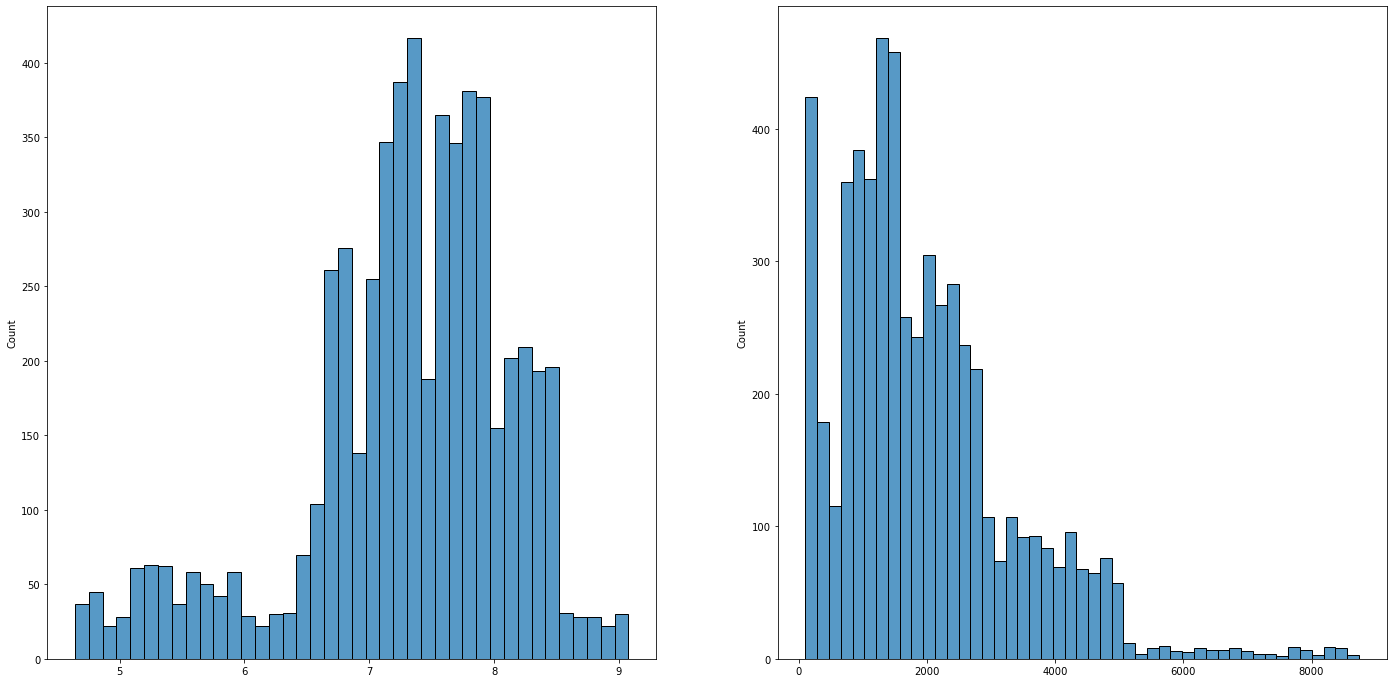

In [67]:
fig, ax = plt.subplots(1, 2, figsize = (24, 12))

sns.histplot(test_predictions, ax = ax[0]);

sns.histplot(test_predictions_inverse_transformed, ax = ax[1]);

## **Conclusions and Recommendations**

- We performed EDA, univariate and bivariate analysis, on all the variables in the dataset.
- We then performed missing values treatment using the relationship between variables.
- We started the model building process with all the features.
- We removed multicollinearity from the data and analyzed the model summary report to drop insignificant features.
- We checked for different assumptions of linear regression and fixed the model iteratively if any assumptions did not hold true.
- Finally, we evaluated the model using different evaluation metrics.

Lastly below is the model equation:

**$\log ($ Item_Outlet_Sales $)$ $= 4.6356 + 1.9555 *$ Item_MRP$ + 0.0158 *$ Item_Fat_Content_Regular $ + 1.9550 *$ Outlet_Type_Supermarket Type1 $ + 1.7737 *$ Outlet_Type_Supermarket Type2$ + 2.4837*$ Outlet_Type_Supermarket Type3**

- From the above equation, we can interpret that, with one unit change in the variable **Item_MRP**, the outcome variable, i.e., log of **Item_Outlet_Sales** increases by 1.9555 units. So, if we want to increase the sales, we may want to store higher MRP items in the high visibility area.

- On average, keeping other factors constant, the log sales of stores with type Supermarket type 3 are 1.4 (2.4837/1.7737) times the log sales of stores with type 2 and 1.27 (2.4837/1.9550) times the log sales of those stores with type 1.

After interpreting this linear regression equation, it is clear that large stores of supermarket type 3 have more sales than other types of outlets. So, we want to maintain or improve the sales in these stores and for the remaining ones, we may want to make strategies to improve the sales, for example, providing better customer service, better training for store staffs, providing more visibility of high MRP item, etc.